In [1]:
import cohere
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import logging

d:\Teias\Thesis\self-explaination-thesis\.venv\lib\site-packages\pydantic\_internal\_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


# Set Api Key

In [2]:
# Set Cohere API key
cohere_api_key = '47amNsxWIPexaTSxCmteAskkxXJ9XVfB2nClzP0j' 
co = cohere.Client(cohere_api_key)

# Read dataset

In [3]:
file_path = "./sample_data.csv"
df = pd.read_csv(file_path)
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,Text,mapped_label
0,بسته بندی تمیز کیفیت محصولات هم بسیار خوب. لطف...,positive
1,سلام. خسته نباشید. واقعا خوشمزه و عالی بود. پی...,positive
2,سیب زمینی با پنیر سفارش داده بودم و سیب زمینی ...,negative
3,سلام واقعنی پیتزا سیب مثل قبل اصلن خوب نبود.. ...,negative
4,خیلی سریع و داغ و لذیذ رسید,positive


# Make functions

In [4]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Function to predict sentiment then generate an explanation (P/E) in Persian with English sentiment labels
def predict_then_explain(review):
    logging.info(f"Starting predict_then_explain for review: {review[:50]}...")  # Log the start and partial review
    prompt = f"""
    First, predict the sentiment of the following review:
    "{review}"
    Then, explain the key reason behind the prediction. 
    Provide the sentiment using only these labels: [positive, negative, neutral]. 
    Provide the explanation in Persian.
    Sentiment: [positive/negative/neutral]
    Explanation: [key reason in Persian]
    """
    try:
        response = co.generate(
            model='command-xlarge-nightly',
            prompt=prompt,
            max_tokens=100,
            temperature=0.3
        )
        result = response.generations[0].text.strip()
        sentiment = result.split("Explanation:")[0].replace("Sentiment:", "").strip()
        explanation = result.split("Explanation:")[1].strip()
        
        logging.info(f"Predicted sentiment (P/E): {sentiment}, Explanation in Persian: {explanation[:50]}...")
        return sentiment, explanation
    except Exception as e:
        logging.error(f"Error in predict_then_explain: {e}")
        return "error", "error"

# Function to generate an explanation first, then predict sentiment (E/P) in Persian with English sentiment labels
def explain_then_predict(review):
    logging.info(f"Starting explain_then_predict for review: {review[:50]}...")  # Log the start and partial review
    prompt = f"""
    First, generate an explanation for the following review:
    "{review}"
    Based on this explanation, predict the sentiment. 
    Provide the explanation in Persian and use only these labels for the sentiment: [positive, negative, neutral].
    Explanation: [key reason in Persian]
    Sentiment: [positive/negative/neutral]
    """
    try:
        response = co.generate(
            model='command-xlarge-nightly',
            prompt=prompt,
            max_tokens=100,
            temperature=0.3
        )
        result = response.generations[0].text.strip()
        explanation = result.split("Sentiment:")[0].replace("Explanation:", "").strip()
        sentiment = result.split("Sentiment:")[1].strip()
        
        logging.info(f"Explanation generated (E/P) in Persian: {explanation[:50]}..., Predicted sentiment: {sentiment}")
        return sentiment, explanation
    except Exception as e:
        logging.error(f"Error in explain_then_predict: {e}")
        return "error", "error"

# Retry function
def make_request_with_retry(func, *args, retries=3, delay=10):
    for attempt in range(retries):
        try:
            return func(*args)
        except ConnectionError as e:
            logging.warning(f"Attempt {attempt + 1} failed: {e}. Retrying in {delay} seconds...")
            time.sleep(delay)
    logging.error("Max retries exceeded")
    raise ConnectionError("Max retries exceeded")

# Function to apply P/E and E/P logic to the dataset
def apply_pe_ep(df):
    results = []
    
    for index, row in df.iterrows():
        original_comment = row['Text']
        original_sentiment = row['mapped_label']
        
        logging.info(f"Processing row {index+1}/{len(df)}: {original_comment[:50]}...")

        # Predict then explain (P/E) with retries, explanation in Persian
        pe_sentiment, pe_explanation = make_request_with_retry(predict_then_explain, original_comment)
        
        # Explain then predict (E/P) with retries, explanation in Persian
        ep_sentiment, ep_explanation = make_request_with_retry(explain_then_predict, original_comment)
        
        # Append the result with separate columns for sentiments and explanations
        results.append({
            "Original Comment": original_comment,
            "Original Sentiment": original_sentiment,
            "P/E Sentiment": pe_sentiment,
            "P/E Explanation (Persian)": pe_explanation,
            "E/P Sentiment": ep_sentiment,
            "E/P Explanation (Persian)": ep_explanation,
        })
        
        logging.info(f"Row {index+1} processed successfully.")

    # Create a new DataFrame with the results
    result_df = pd.DataFrame(results)
    logging.info("Finished processing all rows.")
    return result_df

# Example usage with a dataset
result_df = apply_pe_ep(df)

# Display the final DataFrame
result_df.head()

2024-10-13 11:17:42,642 - Processing row 1/32: بسته بندی تمیز کیفیت محصولات هم بسیار خوب. لطفا در...
2024-10-13 11:17:42,643 - Starting predict_then_explain for review: بسته بندی تمیز کیفیت محصولات هم بسیار خوب. لطفا در...
2024-10-13 11:17:48,342 - HTTP Request: POST https://api.cohere.com/v1/generate "HTTP/1.1 200 OK"
2024-10-13 11:17:48,342 - Predicted sentiment (P/E): positive, Explanation in Persian: این بررسی به نظر مثبت است، زیرا مشتری از بسته‌بندی...
2024-10-13 11:17:48,342 - Starting explain_then_predict for review: بسته بندی تمیز کیفیت محصولات هم بسیار خوب. لطفا در...
2024-10-13 11:17:50,217 - HTTP Request: POST https://api.cohere.com/v1/generate "HTTP/1.1 200 OK"
2024-10-13 11:17:50,217 - Explanation generated (E/P) in Persian: مشتری از پاکیزگی بسته‌بندی و کیفیت بالای محصولات ا..., Predicted sentiment: مثبت
2024-10-13 11:17:50,217 - Row 1 processed successfully.
2024-10-13 11:17:50,217 - Processing row 2/32: سلام. خسته نباشید. واقعا خوشمزه و عالی بود. پیتزا ...
2024-10-13 11:

,Original Comment,Original Sentiment,P/E Sentiment,P/E Explanation (Persian),E/P Sentiment,E/P Explanation (Persian)
0,بسته بندی تمیز کیفیت محصولات هم بسیار خوب. لطف...,positive,positive,این بررسی به نظر مثبت است، زیرا مشتری از بسته‌...,مثبت,مشتری از پاکیزگی بسته‌بندی و کیفیت بالای محصول...
1,سلام. خسته نباشید. واقعا خوشمزه و عالی بود. پی...,positive,positive,این بررسی حاوی نظرات مثبت است، زیرا مشتری از ط...,positive,مشتری از طعم پیتزا و هات داگ راضی بود و آن را ...
2,سیب زمینی با پنیر سفارش داده بودم و سیب زمینی ...,negative,negative,این بررسی حاکی از تجربه منفی مشتری است. مشتری ...,منفی,مشتری از این که سفارش او به درستی آماده نشده ب...
3,سلام واقعنی پیتزا سیب مثل قبل اصلن خوب نبود.. ...,negative,negative,این بررسی نشان دهنده نارضایتی مشتری از کیفیت پ...,negative,مصرف‌کننده از کیفیت پیتزا و حجم سیب‌زمینی در پ...
4,خیلی سریع و داغ و لذیذ رسید,positive,positive,"این بررسی به نظر مثبت است، زیرا از کلمات ""سریع...",positive,مشتری از سرعت تحویل و کیفیت غذا راضی است و آن ...


In [5]:
result_df.to_csv('first_analyze.csv')

In [11]:
import pandas as pd

# Display all rows and columns in the DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_csv('first_analyze.csv')
# Print the DataFrame
df.drop(columns=['Unnamed: 0'], inplace=True)

In [12]:
df

,Original Comment,Original Sentiment,P/E Sentiment,P/E Explanation (Persian),E/P Sentiment,E/P Explanation (Persian)
0,بسته بندی تمیز کیفیت محصولات هم بسیار خوب. لطف...,positive,positive,این بررسی به نظر مثبت است، زیرا مشتری از بسته‌...,مثبت,مشتری از پاکیزگی بسته‌بندی و کیفیت بالای محصول...
1,سلام. خسته نباشید. واقعا خوشمزه و عالی بود. پی...,positive,positive,این بررسی حاوی نظرات مثبت است، زیرا مشتری از ط...,positive,مشتری از طعم پیتزا و هات داگ راضی بود و آن را ...
2,سیب زمینی با پنیر سفارش داده بودم و سیب زمینی ...,negative,negative,این بررسی حاکی از تجربه منفی مشتری است. مشتری ...,منفی,مشتری از این که سفارش او به درستی آماده نشده ب...
3,سلام واقعنی پیتزا سیب مثل قبل اصلن خوب نبود.. ...,negative,negative,این بررسی نشان دهنده نارضایتی مشتری از کیفیت پ...,negative,مصرف‌کننده از کیفیت پیتزا و حجم سیب‌زمینی در پ...
4,خیلی سریع و داغ و لذیذ رسید,positive,positive,"این بررسی به نظر مثبت است، زیرا از کلمات ""سریع...",positive,مشتری از سرعت تحویل و کیفیت غذا راضی است و آن ...
5,خرمالوها له و داغون به دستم رسید,negative,negative,این بررسی به نظر می‌رسد که تجربه‌ای منفی را بی...,negative,مشتری از این ناراضی است که خرمالوها هنگام تحوی...
6,بی نظیر عالی بود,positive,positive,این بررسی به وضوح حاکی از یک تجربه مثبت است، ز...,positive,این بررسی کننده از تجربه خود در یک رستوران یا ...
7,عالی بود ممنونم فقط کاش سبزیجاتم موجود داشتید,positive,positive,این بررسی به نظر مثبت است، زیرا مشتری از تجربه...,مثبت,مشتری از کیفیت محصول راضی است، اما از عدم در د...
8,دونات‌ها یخ کرده بود، من همیشه داغ داغ تحویل م...,positive,negative,این بررسی نشان دهنده نارضایتی مشتری است، زیرا ...,منفی,مشتری از اینکه دونات‌ها یخ زده بودند و با تاخی...
9,غذا سرد بود کیفیت نداشت بنده ساعت ۱۱:۵۵ سفارش ...,negative,negative,این بررسی نشان دهنده یک تجربه منفی است، زیرا م...,منفی,مشتری از کیفیت غذای تحویلی ناراضی است، زیرا آن...


In [13]:
# Iterate over each row in the DataFrame and print the content
for index, row in df.iterrows():
    print(f"Row {index + 1}:")
    print(f"Original Comment: {row['Original Comment']}")
    print(f"Original Sentiment: {row['Original Sentiment']}")
    print(f"P/E Sentiment: {row['P/E Sentiment']}")
    print(f"P/E Explanation (Persian): {row['P/E Explanation (Persian)']}")
    print(f"E/P Sentiment: {row['E/P Sentiment']}")
    print(f"E/P Explanation (Persian): {row['E/P Explanation (Persian)']}")
    print("-" * 50)  # separator between rows

Row 1:
Original Comment: بسته بندی تمیز کیفیت محصولات هم بسیار خوب. لطفا در صورت امکان منو میوه تنوع بیشتری داشته باشد امروز چون موز تو منو نبود از سوپر میوه‌های دیگه اسنپ فود خرید کردم اصلا کیفیت مناسبی نداشت و واقعا تعهد و کیفیت سبزی من بسیار عالی و غیر قابل مقایسه است
Original Sentiment: positive
P/E Sentiment: positive
P/E Explanation (Persian): این بررسی به نظر مثبت است، زیرا مشتری از بسته‌بندی و کیفیت محصولات ابراز رضایت کرده است. آنها از تنوع منو میوه راضی نیستند، اما این موضوع را به عنوان یک درخواست مطرح می‌کنند و همچنان از کیفیت کلی ارائه شده قدردانی می‌کنند.
E/P Sentiment: مثبت
E/P Explanation (Persian): مشتری از پاکیزگی بسته‌بندی و کیفیت بالای محصولات ابراز رضایت کرده است، اما تمایل دارد که منوی میوه‌ها تنوع بیشتری داشته باشد، زیرا مجبور شد موز را از جای دیگری تهیه کند که کیفیت مناسبی نداشت.
--------------------------------------------------
Row 2:
Original Comment: سلام. خسته نباشید. واقعا خوشمزه و عالی بود. پیتزا مخلوط و هات داگ بسیار خوشمزه بود. ممنون از شیلا
Original Sen

In [18]:
df['E/P Sentiment'] = df['E/P Sentiment'].str.strip()
df['E/P Sentiment'] = df['E/P Sentiment'].replace({
    'مثبت': 'positive',
    'منفی': 'negative'
})

# Display the updated DataFrame
df.head()

,Original Comment,Original Sentiment,P/E Sentiment,P/E Explanation (Persian),E/P Sentiment,E/P Explanation (Persian)
0,بسته بندی تمیز کیفیت محصولات هم بسیار خوب. لطف...,positive,positive,این بررسی به نظر مثبت است، زیرا مشتری از بسته‌...,positive,مشتری از پاکیزگی بسته‌بندی و کیفیت بالای محصول...
1,سلام. خسته نباشید. واقعا خوشمزه و عالی بود. پی...,positive,positive,این بررسی حاوی نظرات مثبت است، زیرا مشتری از ط...,positive,مشتری از طعم پیتزا و هات داگ راضی بود و آن را ...
2,سیب زمینی با پنیر سفارش داده بودم و سیب زمینی ...,negative,negative,این بررسی حاکی از تجربه منفی مشتری است. مشتری ...,negative,مشتری از این که سفارش او به درستی آماده نشده ب...
3,سلام واقعنی پیتزا سیب مثل قبل اصلن خوب نبود.. ...,negative,negative,این بررسی نشان دهنده نارضایتی مشتری از کیفیت پ...,negative,مصرف‌کننده از کیفیت پیتزا و حجم سیب‌زمینی در پ...
4,خیلی سریع و داغ و لذیذ رسید,positive,positive,"این بررسی به نظر مثبت است، زیرا از کلمات ""سریع...",positive,مشتری از سرعت تحویل و کیفیت غذا راضی است و آن ...


In [19]:
from IPython.display import display, HTML

# Function to display each row with better formatting
def display_row(row):
    html = f"""
    <div style='border: 1px solid #ddd; padding: 10px; margin-bottom: 10px;'>
        <p><strong>Row {row.name + 1}:</strong></p>
        <p><strong>Original Comment:</strong> {row['Original Comment']}</p>
        <p><strong>Original Sentiment:</strong> {row['Original Sentiment']}</p>
        <p><strong>P/E Sentiment:</strong> {row['P/E Sentiment']}</p>
        <p><strong>P/E Explanation (Persian):</strong> {row['P/E Explanation (Persian)']}</p>
        <p><strong>E/P Sentiment:</strong> {row['E/P Sentiment']}</p>
        <p><strong>E/P Explanation (Persian):</strong> {row['E/P Explanation (Persian)']}</p>
    </div>
    """
    display(HTML(html))

# Apply the display function to all rows
for index, row in df.iterrows():
    display_row(row)

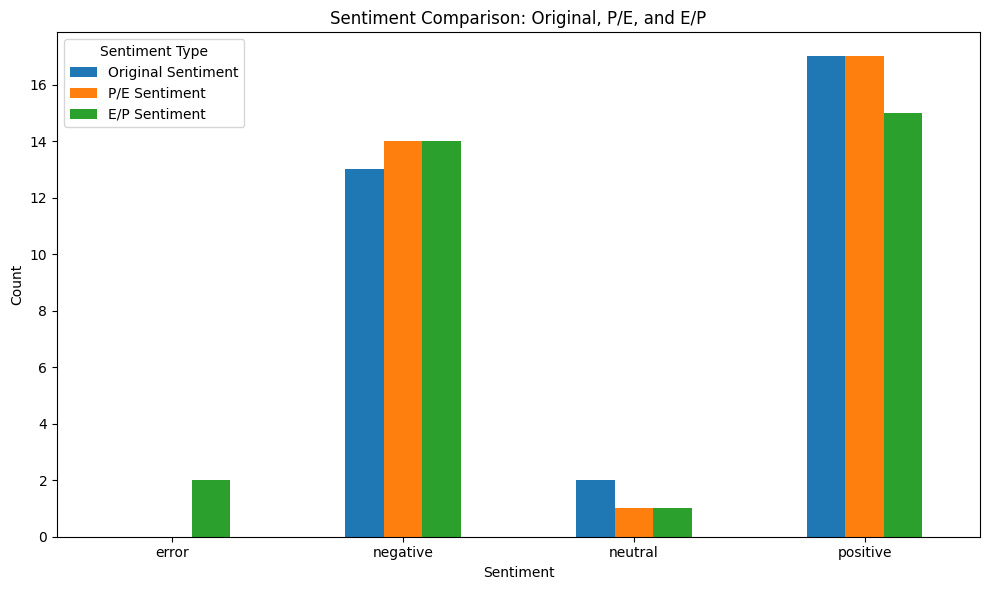

In [20]:
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment in the original, P/E, and E/P columns
original_sentiment_counts = df['Original Sentiment'].value_counts()
pe_sentiment_counts = df['P/E Sentiment'].value_counts()
ep_sentiment_counts = df['E/P Sentiment'].value_counts()

# Create a DataFrame for plotting
sentiment_comparison_df = pd.DataFrame({
    'Original Sentiment': original_sentiment_counts,
    'P/E Sentiment': pe_sentiment_counts,
    'E/P Sentiment': ep_sentiment_counts
}).fillna(0)

# Plot the comparison
sentiment_comparison_df.plot(kind='bar', figsize=(10, 6))

# Customize the plot
plt.title('Sentiment Comparison: Original, P/E, and E/P')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title="Sentiment Type")
plt.tight_layout()

# Show the plot
plt.show()

In [25]:
# Replace 'error' with 'positive' in the 'E/P Sentiment' column
df['E/P Sentiment'] = df['E/P Sentiment'].replace('error', 'positive')

# Verify the replacement
df['E/P Sentiment'].value_counts()

E/P Sentiment
positive    17
negative    14
neutral      1
Name: count, dtype: int64

In [30]:
# Compare Original Sentiment with P/E Sentiment and E/P Sentiment
pe_comparison = (df["Original Sentiment"] == df["P/E Sentiment"]).value_counts()
ep_comparison = (df["Original Sentiment"] == df["E/P Sentiment"]).value_counts()

pe_comparison, ep_comparison

(True     25
 False     7
 Name: count, dtype: int64,
 True     24
 False     8
 Name: count, dtype: int64)

In [39]:
# Generate complete classification reports for both P/E and E/P comparisons
pe_report = classification_report(df["Original Sentiment"], df["P/E Sentiment"], labels=["positive", "negative", "neutral"])
ep_report = classification_report(df["Original Sentiment"], df["E/P Sentiment"], labels=["positive", "negative", "neutral"])

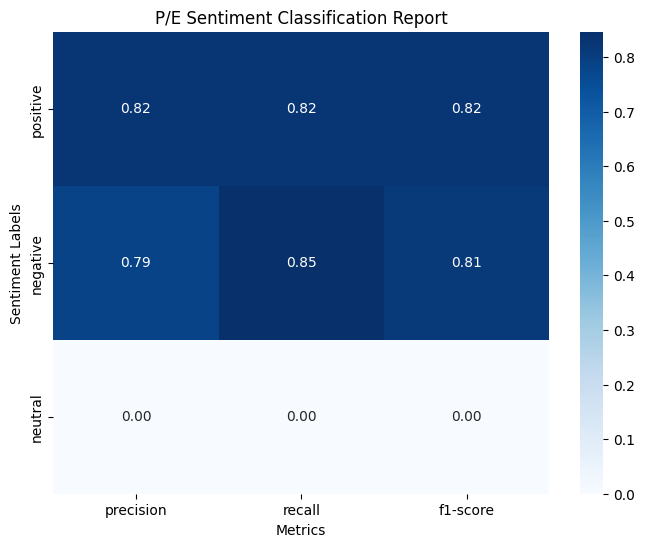

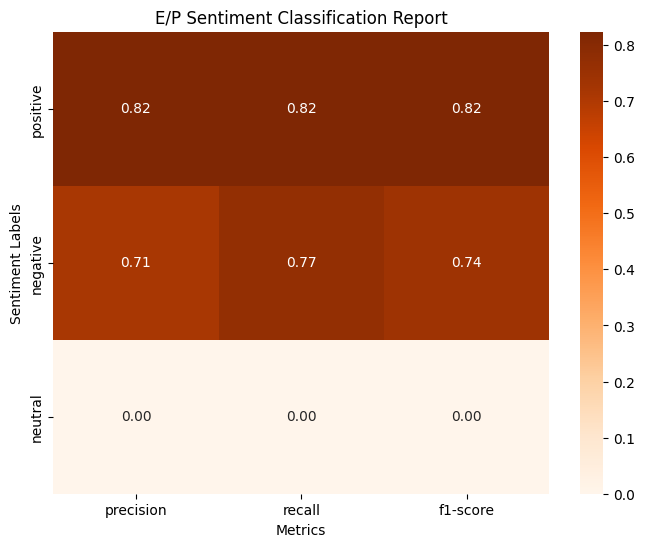

In [41]:
# Generate classification reports
pe_report = classification_report(df["Original Sentiment"], df["P/E Sentiment"], labels=["positive", "negative", "neutral"], output_dict=True)
ep_report = classification_report(df["Original Sentiment"], df["E/P Sentiment"], labels=["positive", "negative", "neutral"], output_dict=True)

# Convert reports to dataframes
pe_df = pd.DataFrame(pe_report).transpose()
ep_df = pd.DataFrame(ep_report).transpose()

# Select the metrics you want to visualize
metrics = ['precision', 'recall', 'f1-score']
labels = ["positive", "negative", "neutral"]

# Prepare data for heatmap
pe_data = pe_df.loc[labels, metrics].values
ep_data = ep_df.loc[labels, metrics].values

# Create a heatmap for P/E comparison
plt.figure(figsize=(8, 6))
sns.heatmap(pe_data, annot=True, fmt=".2f", cmap="Blues", xticklabels=metrics, yticklabels=labels)
plt.title("P/E Sentiment Classification Report")
plt.ylabel('Sentiment Labels')
plt.xlabel('Metrics')
plt.show()

# Create a heatmap for E/P comparison
plt.figure(figsize=(8, 6))
sns.heatmap(ep_data, annot=True, fmt=".2f", cmap="Oranges", xticklabels=metrics, yticklabels=labels)
plt.title("E/P Sentiment Classification Report")
plt.ylabel('Sentiment Labels')
plt.xlabel('Metrics')
plt.show()